In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
from math import sqrt, exp
import scipy.linalg as la
from sklearn import cluster, datasets

In [2]:
def read_and_convert_data(data_path, labels_path):
    """
    read_and_convert_data_points is a function that takes
    a text file as an argument and converts it into an 
    array containing all the datapoints.
    ======================================================
    :param filename: text file name in directory.
    :return: Npts x 2 array, labels vector of length Npts. 
    ======================================================
    """
    splits = []
    with open(data_path, 'r') as d, open(labels_path, 'r') as l:
                data_points = d.readlines()
                data_labels = l.readlines()
    
    for data_point in data_points:
        splits.append(data_point.split())
    
    return (np.array(splits, dtype=np.float),
            np.array(data_labels, dtype=np.int))

In [3]:
def scatter_plot_data_set(data,labels, color_clusters = True):
    """
    scatter_plot_data_set is a function that plots the data.
     ======================================================
    :param data: Npts x 2, data set array.
    :labels: Npts labels vector.
    :return:
     ======================================================
    """
    x, y = data.T
    colors = ['red','orange','blue']
    if color_clusters:
        plt.scatter(x,y,c=labels, 
                cmap=matplotlib.colors.ListedColormap(colors))
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
    else:
        plt.scatter(x,y, c="black")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

In [4]:
def eucledian_dist(x_i, x_j):
    """
    eucledian_dist is a function that 
     ======================================================
    :param x_i: 
    :x_j: 
    :return:
     ======================================================
    """
    coord = x_i.shape[0]
    d=[]
    if coord == x_j.shape[0]:
        for i in range(coord):
            d.append((x_i[i] - x_j[i])**2)
    return (np.sqrt(sum(d),dtype=np.float64))

In [5]:
def distance_matrix(data, distance_measure):
    """
    distance_matrix is a function that 
     ======================================================
    :param data: 
    :distance_measure: 
    :return:
     ======================================================
    """
    Npts= data.shape[0]
    distance_matrix=np.zeros((Npts,Npts))
    for xi in range(Npts):
        for xj in range(Npts):
            distance_matrix[xi,xj] = distance_measure(data[xi],data[xj])
    return(distance_matrix)

In [6]:
def adjacency_matrix(data, sigma):
    """
    adjacency_matrix is a function that 
     ======================================================
    :param data: 
    :sigma: 
    :return:
     ======================================================
    """
    dist_matrix = distance_matrix(data, eucledian_dist)
    adjacency_matrix= np.exp(-(dist_matrix)**2 /sigma)
    adjacency_matrix[adjacency_matrix==1] = 0
    return(adjacency_matrix)

In [7]:
def diagonal_matrix(adjacency_matrix):
    """
    diagonal_matrix is a function that 
     ======================================================
    :param adjacency_matrix: 
    :return:
     ======================================================
    """
    return(np.diag(sum(adjacency_matrix)))

In [8]:
def unnormalized_graph_Laplacian(adjacency_matrix):
    """
    unnormalized_graph_Laplacian is a function that 
     ======================================================
    :param adjacency_matrix: 
    :return:
     ======================================================
    """
    diag_matrix = diagonal_matrix(adjacency_matrix)
    if diag_matrix.shape == adjacency_matrix.shape:
        return(diag_matrix - adjacency_matrix)

In [9]:
def normalized_graph_Laplacian(adjacency_matrix, matrix = "symmetric"):
    """
    normalized_graph_Laplacian is a function that 
     ======================================================
    :param adjacency_matrix: 
    :matrix:
    :return:
     ======================================================
    """
    D = diagonal_matrix(adjacency_matrix)
    L = unnormalized_graph_Laplacian(adjacency_matrix)
    if matrix == "symmetric":
        return(np.matmul(np.matmul(np.diag(sum(D)**(-1/2)),L)
                         ,np.diag(sum(D)**(-1/2))))
    if matrix == "rw":
        return(np.matmul(np.diag(sum(D)**(-1)), L))

# 1- Spiral Dataset

In [10]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [11]:
data_points, data_labels = read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape

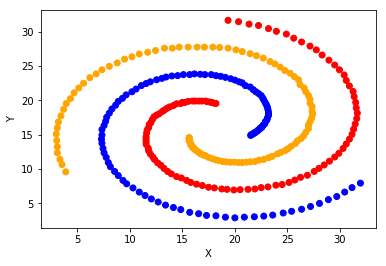

In [12]:
scatter_plot_data_set(data_points, data_labels)

In [13]:
W = adjacency_matrix(data_points, sigma=0.5)
L_unnormalized =unnormalized_graph_Laplacian(W)
L_symmetric = normalized_graph_Laplacian(W, matrix = "symmetric")
L_random_walk = normalized_graph_Laplacian(W, matrix = "rw")

In [14]:
#Sanity check: Symmetric matrix
np.allclose(L_unnormalized, L_unnormalized.T)

True

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(L_unnormalized)
eigenvalues = eigenvalues.real
eigenvalues.sort()
rearrangedEvalsVecs = sorted(zip(eigenvalues,eigenvectors.T),key=lambda x: x[0])

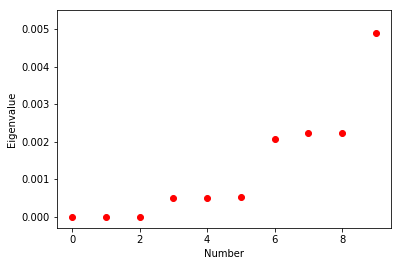

In [16]:
plt.scatter([i for i in range(10)], eigenvalues[0:10],c="red")
plt.ylim(-0.0003, 0.0055)
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')
plt.show()

# 2- Half-moon Dataset

In [17]:
#Generate data
half_moons_data = datasets.make_moons(n_samples=35, noise=.045, random_state=1991)

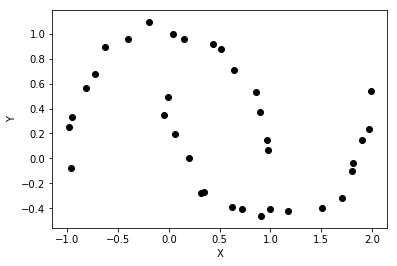

In [18]:
#plot data
scatter_plot_data_set(half_moons_data[0], half_moons_data[1], color_clusters = False)

In [19]:
W_half_moon = adjacency_matrix(half_moons_data[0], sigma=0.5)

In [20]:
Npts = W_half_moon.shape[0]
nodes_idx = [i for i in range(Npts)]
nodes_position = dict()
for key  in nodes_idx:
    nodes_position[key] = list(half_moons_data[0][key])
hm = nx.Graph()
hm.add_nodes_from(nodes_idx)
#hm.add_edges_from([(i,j) for i in range(Npts)for j in range(Npts)])
hm.add_weighted_edges_from([(i,j, W_half_moon[i][j]) for i in range(Npts) for j in range(Npts)])

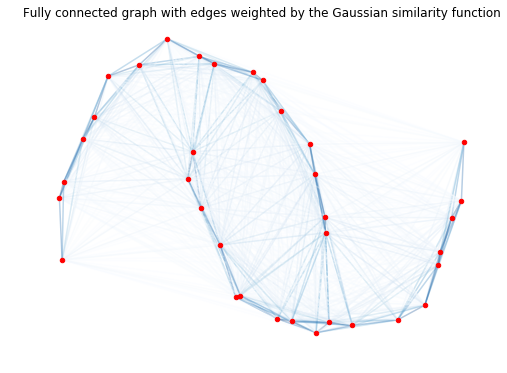

In [22]:
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(hm)
nx.draw_networkx_nodes(hm, nodes_position, node_size=20, node_color="red")
nx.draw_networkx_edges(hm, nodes_position, edge_cmap= plt.cm.Blues,
                       width=1.5, edge_color=[hm[u][v]['weight'] for u, v in hm.edges],
                       alpha=0.3)
plt.axis('off')
plt.title('Fully connected graph with edges weighted by the Gaussian similarity function')
plt.show()